# Demonstration Unsymmetrical bending

In [2]:
import sympy as sym
sym.init_printing()

In [3]:
x = sym.symbols('x')
F_z, F_y = sym.symbols('F_z F_y')
C1, C2, C3, C4 = sym.symbols('C1 C2 C3 C4')
qz = sym.SingularityFunction(x,750,-1)*1000 * F_z
Vz = -sym.integrate(qz,x) + C1
Mz = sym.integrate(Vz,x)
qy = sym.SingularityFunction(x,750,-1)*1000 * F_y
Vy = -sym.integrate(qy,x) + C3
My  =sym.integrate(Vy,x)

eq2 = sym.Eq(Mz.subs(x,1500),0)
eq4 = sym.Eq(My.subs(x,1500),0)
sol = sym.solve([eq2,eq4],(C1,C3))
Mz = Mz.subs(sol)
My = My.subs(sol)

In [4]:
b = 75
h = 150
t = 10
A = b*t+h*t - t*t
NC_z = ( (b-t) * t * t/2 + h * t * h / 2 ) / A
NC_y = ( (h-t)*t*t/2 + b * t * b / 2 ) / A
Izz = (1/12 * (b-t) * t **3 + 1/12 * t * h**3 + b * t * (NC_z-t/2)**2 + h * t * (NC_z - h/2)**2)/1e4
Iyy = (1/12 * t * b **3 + 1/12 * (h - t) * t**3 + h * t * (t/2-NC_y)**2 + b * t * (NC_y - b/2)**2)/1e4
Iyz = (b * t * (b/2 - NC_y) * (- NC_z+t/2) + h * t * (- NC_y+t/2) * (h / 2 - NC_z) - t * t * (-NC_y + t/2) * (-NC_z + t/2))/1e4

E = 210000
kappa_y = 1e-4/E*1/(Izz*Iyy-(-Iyz)**2)*( Izz*My - Iyz*Mz)
kappa_z = 1e-4/E*1/(Izz*Iyy-(-Iyz)**2)*( -Iyz*My + Iyy*Mz)

In [5]:
phi_y = sym.integrate(kappa_z.subs(b,500).subs(h,150).subs(t,30),x) + C1
phi_z = -sym.integrate(kappa_y.subs(b,500).subs(h,150).subs(t,30),x) + C2
w_y = sym.integrate(phi_z,x)
w_z = -sym.integrate(phi_y,x)

eq3 = sym.Eq(w_y.subs(x,1500),0)
eq4 = sym.Eq(w_z.subs(x,1500),0)
sol = sym.solve([eq3,eq4],(C1,C2))
y, z = sym.symbols('y z')

u = - y * phi_z + z * phi_y

In [10]:
w_y_num = sym.lambdify([x,F_z,F_y],w_y.subs(sol).rewrite(sym.Piecewise))
w_z_num = sym.lambdify([x,F_z,F_y],w_z.subs(sol).rewrite(sym.Piecewise))
u_num = sym.lambdify([x,F_z,F_y,y,z],u.subs(sol).rewrite(sym.Piecewise))

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from mpl_toolkits.mplot3d.art3d import Poly3DCollection 
%matplotlib widget

In [ ]:
def add_surface_between_lines(x_left, x_right, y_left, y_right, z_left, z_right, ax,color):
    for i in range(len(x_left)-1):
        vertices = []
        vertices.append([x_left[i], y_left[i], z_left[i]])
        vertices.append([x_right[i], y_right[i], z_right[i]])
        vertices.append([x_right[i+1], y_right[i+1], z_right[i+1]])
        surface = Poly3DCollection([vertices], alpha=0.5, facecolor=color)
        ax.add_collection3d(surface)
    for i in range(len(x_left)-1):
        vertices = []
        vertices.append([x_left[i], y_left[i], z_left[i]])
        vertices.append([x_right[i+1], y_right[i+1], z_right[i+1]])
        vertices.append([x_left[i+1], y_left[i+1], z_left[i+1]])
        surface = Poly3DCollection([vertices], alpha=0.5, facecolor=color)
        ax.add_collection3d(surface)


interactive(children=(IntSlider(value=20, description='Fz:', max=40), IntSlider(value=20, description='Fy:', m…

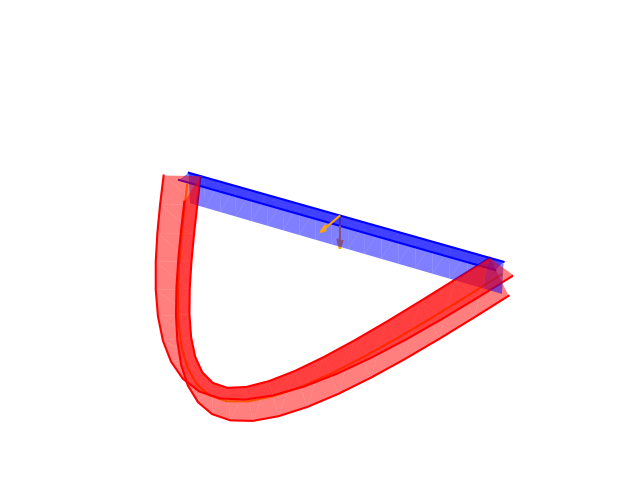

In [20]:
Fz_slider = widgets.IntSlider(value=20, min=0, max=40, step=1, description='Fz:')
Fy_slider = widgets.IntSlider(value=20, min=0, max=40, step=1, description='Fy:')
scale_slider = widgets.IntSlider(value=71, min=1, max=100, step=10, description='Scale:')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a function to update the plot based on the slider values
def update_plot(Fz, Fy, scale):
    ax.clear()  # Clear the existing plot
    x_num = np.linspace(0, 1500, 20)

    ax.set_ylim3d(-16, 100)
    ax.set_zlim3d(-52, 100)
    ax.set_xlim3d(0, 1500)
    ax.invert_zaxis()
    ax.invert_yaxis()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.quiver(750, -15.83, -51.67, 0, 0, Fz, length=Fz/50*20, normalize=False, color='orange')
    ax.quiver(750, -15.83, -51.67, 0, Fy, 0, length=Fy/50*20, normalize=False, color='orange')

    w_y_eval = w_y_num(x_num, F_z=Fz, F_y=Fy) * scale
    w_z_eval = w_z_num(x_num, F_z=Fz, F_y=Fy) * scale

    ax.plot(x_num, w_y_eval, w_z_eval, color='orange')

    y_left = np.ones_like(x_num) * (75 - 15.83)
    y_right = np.ones_like(x_num) * (-15.83)
    z_left = np.ones_like(x_num) * -51.67
    z_right = np.ones_like(x_num) * -51.67
    x_left = x_num + u_num(x_num, F_z=Fz, F_y=Fy, y=y_left, z=z_left) * scale
    x_right = x_num + u_num(x_num, F_z=Fz, F_y=Fy, y=y_right, z=z_right) * scale
    add_surface_between_lines(x_left, x_right, w_y_eval + y_left, w_y_eval + y_right, w_z_eval + z_left, w_z_eval + z_right, ax, color='red')
    ax.plot(x_left, w_y_eval + y_left, w_z_eval + z_left, color='red')
    ax.plot(x_right, w_y_eval + y_right, w_z_eval + z_right, color='red')

    y_left = np.ones_like(x_num) * (-15.83)
    z_left = np.ones_like(x_num) * (150 - 51.67)
    x_left = x_num + u_num(x_num, F_z=Fz, F_y=Fy, y=y_left, z=z_left) * scale
    add_surface_between_lines(x_left, x_right, w_y_eval + y_left, w_y_eval + y_right, w_z_eval + z_left, w_z_eval + z_right, ax, color='red')
    ax.plot(x_left, w_y_eval + y_left, w_z_eval + z_left, color='red')

    y_left = np.ones_like(x_num) * (75 - 15.83)
    y_right = np.ones_like(x_num) * (-15.83)
    z_left = np.ones_like(x_num) * -51.67
    z_right = np.ones_like(x_num) * -51.67
    add_surface_between_lines(x_num, x_num, y_left, y_right, z_left, z_right, ax, color='blue')
    ax.plot(x_num, y_left, z_left, color='blue')
    ax.plot(x_num, y_right, z_right, color='blue')

    y_left = np.ones_like(x_num) * (-15.83)
    z_left = np.ones_like(x_num) * (150 - 51.67)
    add_surface_between_lines(x_num, x_num, y_left, y_right, z_left, z_right, ax, color='blue')

    plt.draw()  # Redraw the updated plot

# Display the sliders and the plot
widgets.interact(update_plot, Fz=Fz_slider, Fy=Fy_slider, scale=scale_slider);
